Model has 108k params
Initial training loss: 4.286508560180664, val loss: 4.308408737182617
iter:0 training loss: 4.293029308319092, val loss: 4.306211948394775
iter:250 training loss: 3.2717132568359375, val loss: 3.284799814224243
iter:500 training loss: 2.849111557006836, val loss: 2.870640754699707
iter:750 training loss: 2.6973929405212402, val loss: 2.696725368499756
iter:1000 training loss: 2.619516611099243, val loss: 2.6281824111938477
iter:1250 training loss: 2.5904483795166016, val loss: 2.5947484970092773
iter:1500 training loss: 2.55301570892334, val loss: 2.559114456176758
iter:1750 training loss: 2.532179355621338, val loss: 2.5478110313415527
iter:2000 training loss: 2.5299954414367676, val loss: 2.541569709777832
iter:2250 training loss: 2.5163114070892334, val loss: 2.5340359210968018
iter:2500 training loss: 2.5067636966705322, val loss: 2.5217113494873047
iter:2750 training loss: 2.4908740520477295, val loss: 2.5233981609344482
iter:3000 training loss: 2.48877191543

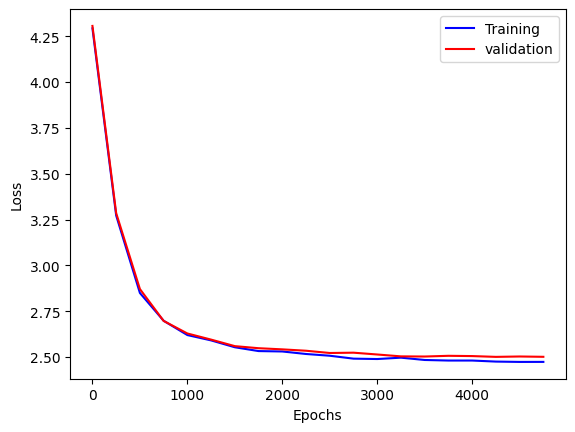

yount frto trsouer IVOLA:

JUBOFrdycatowhe!'dar t git nknes ande anowisou, oditile ft ule sur wic:

kie

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math
PATH = "models/pavan_gpt_100k_1.91.bin"
LOAD_MODEL = False


torch.manual_seed(1)

inf = torch.inf
context_length = 16 # No of tokens
model_dim = 64 # dimension of the model -> residual stream
n_layers = 2 # no of layers
n_heads = 0 # No of attention heads for layer # TODO
head_dim = 64
vocab_size = 65
learning_rate = 3e-4
max_iters = 5000
eval_iters = 100
batch_size = 32 #Takes 27k iters

lower_triangular_matrix = torch.tensor([[1 if i<=j else -torch.inf for i in range(context_length)] for j in range(context_length)]).float()

def tokenise(str: str):
    return torch.tensor([char_map[i] for i in str])

def decode(tokens: list[str]):
    return ''.join([reverse_char_map[i] for i in tokens])

file = open("tiny_shakesphere.txt", "r")
full_data = file.read()

vocab = list(sorted((set(full_data))))

char_map = {vocab[i]: i for i in range(len(vocab))}
reverse_char_map = {char_map[i] : i for i in char_map}
full_data = tokenise(full_data)

total_datapoints  = full_data.shape[0]

training_data : list[int] = full_data[:int(total_datapoints*0.9)]
validation_data = full_data[int(total_datapoints*0.9):total_datapoints]


def sample_data(split: str = "train"): # With replacement
    data = training_data if split == 'train' else validation_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class Layer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
        self.dropout = nn.Dropout(0.2)
    

    def version_1(self, idx):
        pass
        

    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        attention_value = self.proj(attention_value)  # (batch, context_length, model_dim)
        return self.dropout(attention_value)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.ReLU(), nn.Linear(4*model_dim, model_dim))
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, idx):
        logits = self.layers(idx)
        return self.dropout(logits)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layes = nn.ModuleList([AttentionHead() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        # for p in range(idx.shape[0]):
        #     print([decode(idx[p].tolist()), decode(targets[p].tolist())])

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        # residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(0):
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)
            residual_stream = residual_stream + self.mlp_layers[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        (x,y,z) = residual_stream.shape
        loss = F.cross_entropy(residual_stream.view(x*y,z), targets.view(x*y))
        return residual_stream, loss
    

model = Transformer()


if LOAD_MODEL:
    model = Transformer()
    model.load_state_dict(torch.load(PATH))
    model.eval()

train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)
        loss_value.append(train_loss)
        val_loss_value.append(val_loss)
        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()

generate_text("you")  

In [2]:
def generate_text(input: str):
    max_tokens = 100
    input_tokens = tokenise(input)
    print(input, end='')
    
    for i in range(max_tokens):
        now = model(input_tokens.unsqueeze(0))[0][-1]
        now = F.softmax(now, dim= 0)
        token = torch.multinomial(now,1).item()
        input_tokens = torch.tensor(input_tokens.tolist() + [token])
        text = decode([token])
        print(text, end='')
        input_tokens = input_tokens[-context_length:]
                



youruLauYmEW$zH$Bbz,jVVqj,To,qhfuauTByjZ!YO?3hgkxVZ?$&Q?y.rLDLoJ Tkw ,$$jVNzkcAbfgcyphB,Xd':NWCXQXcM-cP

In [7]:
model(tokenise("h")).argmax()

tensor(43)

In [18]:
for char in vocab:
    print(char, " ", vocab[model(tokenise(char)).argmax().item()])


   

    t
!   

$   o
&   U
'   s
,    
-   -
.   

3   A
:   

;    
?   

A   n
B   u
C   E
D   U
E   N
F   o
G    
H   e
I    
J   U
K   I
L   A
M   E
N   G
O   :
P   O
Q   U
R   I
S   :
T   h
U   S
V   I
W   h
X   E
Y   o
Z    
a   n
b   e
c   e
d    
e    
f    
g    
h   e
i   n
j   o
k   e
l   l
m   e
n   d
o   u
p   e
q   u
r    
s    
t   h
u   r
v   e
w   i
x   e
y    
z   e


In [20]:
from azure.storage.blob import BlobServiceClient, BlobClient

# URL of the Blob Storage
storage_url = "https://openaipublic.blob.core.windows.net/neuron-explainer"

# Create a BlobServiceClient to interact with the Blob storage
blob_service_client = BlobServiceClient(account_url=storage_url)

# Define the layer and neuron indices
layer_index = 1
neuron_index = 1

# Construct the blob name (path to the file in the storage)
blob_name = f"data/collated-activations/{layer_index}/{neuron_index}.json"

# Create a BlobClient to interact with the specific blob
blob_client = blob_service_client.get_blob_client(container="neuron-explainer", blob=blob_name)

# Download the blob's content
with open(f"neuron_{neuron_index}_layer_{layer_index}.json", "wb") as download_file:
    download_file.write(blob_client.download_blob().readall())

print("Download completed")


ResourceNotFoundError: The specified blob does not exist.
RequestId:9af944e2-401e-00b9-1d9d-1ed8d5000000
Time:2023-11-24T06:17:15.5625418Z
ErrorCode:BlobNotFound
Content: <?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.
RequestId:9af944e2-401e-00b9-1d9d-1ed8d5000000
Time:2023-11-24T06:17:15.5625418Z</Message></Error>